# Index arXiv papers into Elasticsearch

This notebook processes arXiv papers using PySpark, cleaning and normalizing metadata (titles, abstracts, authors, categories), then performs text processing (tokenization, stopword removal, TF-IDF calculation) to prepare the data for indexing in Elasticsearch for efficient searching.

Tokenization breaks text into individual words, making it possible to analyze and search text at the word level.

TF-IDF (Term Frequency-Inverse Document Frequency) calculation assigns importance scores to words based on how frequently they appear in a document versus the entire corpus. This helps identify distinctive terms in each document while downplaying common words, improving search relevance by prioritizing unique, meaningful terms when matching queries to documents.

When this session starts, Spark will download the Elasticsearch Hadoop connector package if not already present​.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Arxiv-Index-into-Elasticsearch") \
    .master("local[*]") \
    .config("spark.jars.packages", 
            "org.elasticsearch:elasticsearch-spark-30_2.12:8.8.2") \
    .getOrCreate()

Next, load the JSON dataset into a DataFrame. The file is in JSONL format, so each line is a separate JSON record. We can use spark.read.json which will parse each line into a row.

In [2]:
# Path to the JSON file (adjust if necessary)
data_path = "../data/arxiv-metadata-oai-snapshot.json"

# Load the JSON file into a DataFrame, selecting only the fields of interest
df = spark.read.json(data_path) \
        .select("id", "title", "abstract", "authors", "categories")

# Print the schema and number of records to verify
df.printSchema()
print("Total records:", df.count())
df.show(5)

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- categories: string (nullable = true)

Total records: 2694879
+---------+--------------------+--------------------+--------------------+---------------+
|       id|               title|            abstract|             authors|     categories|
+---------+--------------------+--------------------+--------------------+---------------+
|0704.0001|Calculation of pr...|  A fully differe...|C. Bal\'azs, E. L...|         hep-ph|
|0704.0002|Sparsity-certifyi...|  We describe a n...|Ileana Streinu an...|  math.CO cs.CG|
|0704.0003|The evolution of ...|  The evolution o...|         Hongjun Pan| physics.gen-ph|
|0704.0004|A determinant of ...|  We show that a ...|        David Callan|        math.CO|
|0704.0005|From dyadic $\Lam...|  In this paper w...|Wael Abu-Shammala...|math.CA math.FA|
+---------+--------------------+-------------------

This will load the metadata. The select filters the DataFrame to only relevant columns to save memory. The schema should list each field and their types (all should be strings, except possibly categories could be a string of space-separated categories). 

You should see that 2.6+ million records were loaded (which may take a bit of time for the count). 


Now let's clean and normalize the fields:
- Remove any newline characters or excessive whitespace in titles and abstracts.
- Convert text to lowercase for consistent processing.
- Clean the authors field (e.g., remove line breaks, unify separators).
- Split the categories field into an array of individual category codes, since categories in the raw data might be a single string of space-separated codes​.

We'll use PySpark SQL functions to do this in a vectorized way

In [3]:
from pyspark.sql.functions import regexp_replace, trim, lower, split

# Remove newlines and excessive whitespace in title and abstract, and trim
df_clean = df.withColumn("title", trim(regexp_replace("title", r"[\r\n]+", " "))) \
             .withColumn("abstract", trim(regexp_replace("abstract", r"[\r\n]+", " "))) \
             .withColumn("title", regexp_replace("title", r"\s+", " ")) \
             .withColumn("abstract", regexp_replace("abstract", r"\s+", " "))

# Optionally, make text lowercase (for consistent analysis, though Elasticsearch will handle casing)
df_clean = df_clean.withColumn("title", lower("title")) \
                   .withColumn("abstract", lower("abstract")) \
                   .withColumn("authors", lower("authors"))

# Normalize authors: replace ' and ' with comma, remove trailing ' and'
df_clean = df_clean.withColumn("authors", regexp_replace("authors", r"\sand\s", ", ")) \
                   .withColumn("authors", regexp_replace("authors", r"\s+", " "))

# Split categories into array of category codes
df_clean = df_clean.withColumn("categories", split("categories", " "))


df_clean.printSchema()
print("Total records:", df.count())
df_clean.show(5)

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = false)

Total records: 2694879
+---------+--------------------+--------------------+--------------------+------------------+
|       id|               title|            abstract|             authors|        categories|
+---------+--------------------+--------------------+--------------------+------------------+
|0704.0001|calculation of pr...|a fully different...|c. bal\'azs, e. l...|          [hep-ph]|
|0704.0002|sparsity-certifyi...|we describe a new...|ileana streinu, l...|  [math.CO, cs.CG]|
|0704.0003|the evolution of ...|the evolution of ...|         hongjun pan|  [physics.gen-ph]|
|0704.0004|a determinant of ...|we show that a de...|        david callan|         [math.CO]|
|0704.0005|from dyadic $\lam...|in this paper we ...|wael abu-shammala...

The above transformations:
- Use regexp_replace to replace newlines (\r\n) with spaces and condense multiple spaces to one.
- Lowercase the text in title, abstract, authors.
- In authors, attempt to replace the word " and " with a comma+space, so that authors like "Smith and Doe" become "Smith, Doe", then all multiple spaces condensed. This way authors are separated uniformly by commas.
- Split the categories string on spaces into an array (e.g., "cs.AI cs.CL" becomes ["cs.AI","cs.CL"]).

## Text Processing and Feature Extraction

With clean text data, we can proceed to text processing steps. 

We will tokenize the text and remove stop words, then compute TF-IDF features for the documents. (These features are not strictly needed for Elasticsearch, since Elasticsearch computes its own inverted index and scoring, but we include them as part of the pipeline for analysis or optional use.)



#### Tokenization and Stopword Removal

We will tokenize the abstract, and then remove common stop words (like "the", "and", "of", etc.) which are not useful in search queries. 

PySpark's ML library provides Tokenizer/RegexTokenizer and StopWordsRemover for this purpose. 

In [4]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover

# Tokenizer to split text on non-word characters (this will break text into words)
tokenizer = RegexTokenizer(inputCol="abstract", outputCol="words", pattern="\\W")
words_data = tokenizer.transform(df_clean)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_data = remover.transform(words_data)

filtered_data.select("abstract", "filtered_words").show(3, truncate=80)


+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                                                        abstract|                                                                  filtered_words|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|a fully differential calculation in perturbative quantum chromodynamics is pr...|[fully, differential, calculation, perturbative, quantum, chromodynamics, pre...|
|we describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use ...|[describe, new, algorithm, k, ell, pebble, game, colors, use, obtain, charact...|
|the evolution of earth-moon system is described by the dark matter field flui...|[evolution, earth, moon, system, described, dark, matter, field, fluid, model...|
+---------------

#### Computing TF-IDF Features
Next, we compute TF-IDF (Term Frequency–Inverse Document Frequency) vectors for the documents. **TF-IDF is a numerical statistic that reflects how important a word is to a document in a corpus​**. 

We will use Spark's HashingTF to hash words into term frequency vectors, then IDF to scale them.

In [5]:
from pyspark.ml.feature import HashingTF, IDF

# HashingTF to map the filtered words to a fixed-length feature vector
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=10000)
featurized_data = hashingTF.transform(filtered_data)
# Compute the IDF model on the corpus
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurized_data)
rescaled_data = idfModel.transform(featurized_data)

# Check the TF-IDF feature vector for a sample
rescaled_data.select("id", "features").show(3, truncate=80)


+---------+--------------------------------------------------------------------------------+
|       id|                                                                        features|
+---------+--------------------------------------------------------------------------------+
|0704.0001|(10000,[134,157,282,436,717,944,1072,1080,1113,1161,1226,1253,1439,1481,1695,...|
|0704.0002|(10000,[221,274,310,521,585,625,705,870,885,1055,1296,1468,1541,2093,2241,225...|
|0704.0003|(10000,[20,157,253,258,316,327,399,617,697,735,922,1016,1038,1622,1695,1896,1...|
+---------+--------------------------------------------------------------------------------+
only showing top 3 rows



## Enhancing Search with Document Clustering

While Elasticsearch provides powerful text search capabilities, we can further enhance the search experience by adding document clustering. This approach groups similar papers together based on their content, creating an additional dimension for search and discovery.

### Why Clustering Matters

Clustering documents offers several advantages:

1. **Content-Based Similarity**: Papers with similar content are grouped together, even if they don't share exact keywords
2. **Topic Discovery**: Clusters often represent distinct research areas or topics. With adanced enough clustering, we can find subtopics within topics.
3. **Improved Search Relevance**: Combining text search with cluster filtering can yield more relevant results
4. **Serendipitous Discovery**: Users can explore related papers within a cluster, discovering connections they might have missed

### Implementation Details

We implement K-means clustering using the TF-IDF vectors we calculated earlier:

1. **K-means Algorithm**: We use Spark's K-means implementation to group documents into 20 clusters (this number can be adjusted)
2. **Silhouette Evaluation**: We calculate the Silhouette score to evaluate clustering quality (values closer to 1 indicate better-defined clusters)
3. **Cluster Assignment**: Each document is assigned a cluster ID (0-19) based on its TF-IDF vector
4. **Elasticsearch Integration**: The cluster ID is added as a field to each document in Elasticsearch

### Using Clusters in Search

The cluster information enables powerful search patterns:


In [7]:
# Clustering papers based on TF-IDF vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col

# Define the K-means model
# We'll use 20 clusters as a starting point - you can adjust this number
kmeans = KMeans(k=50, seed=1, featuresCol="features")

# Train the model
model = kmeans.fit(rescaled_data)

# Make predictions
predictions = model.transform(rescaled_data)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol="features")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

# Show cluster centers
centers = model.clusterCenters()
print(f"Cluster Centers: {len(centers)}")

Silhouette with squared euclidean distance = -0.027632080555788373
Cluster Centers: 20


That silhouette score was not good. Either k-means is not the right algoritm or we have too few clusters.

## Using Chi-Square Feature Selection Instead of PCA

In our clustering pipeline, we've chosen to use Chi-Square Feature Selection instead of Principal Component Analysis (PCA) for dimensionality reduction. Here's why this approach is more suitable for our large-scale document clustering task:

### Memory Efficiency

**PCA's Memory Challenge:**
- PCA requires computing a covariance matrix of size (dimensions × dimensions)
- With our 10,000 TF-IDF features, this creates a 10,000 × 10,000 matrix = 100 million entries
- Just storing this matrix requires approximately 8GB of memory (assuming 8 bytes per double)
- The eigenvalue decomposition of this matrix requires additional substantial memory

**Chi-Square Selector Advantage:**
- Works by evaluating each feature independently against the target variable
- Doesn't require creating massive matrices of feature interactions
- Memory requirements scale linearly with the number of features, not quadratically
- Can process high-dimensional data with much lower memory footprint

While in production PCA is less of an issue, this is all being run on my 2020 intel based macbook pro with just 16 GB of memory....7

### How Chi-Square Selection Works

The Chi-Square Selector:
1. Evaluates the relationship between each feature and a target variable using the chi-square test
2. Ranks features based on their chi-square statistic values
3. Selects the top N features with the highest scores

For our document clustering, we created a temporary random label column to enable the feature selection process. While this doesn't provide optimal feature selection (since the labels are random), it still effectively reduces dimensionality by selecting features with statistical variation across the dataset.

### Benefits for Clustering

By reducing our feature space from 10,000 to 1,000 dimensions:
- We maintain the most informative features for distinguishing between documents
- We improve the performance of K-means clustering by reducing the "curse of dimensionality"
- We significantly reduce computation time and memory requirements
- We enable more efficient storage and processing of document vectors

This approach provides a practical balance between computational efficiency and clustering quality, making it possible to process our large corpus of 2.6 million academic papers without overwhelming our computational resources.

Applying ChiSqSelector to reduce dimensions...
Finding optimal K using Elbow Method...
Training K-means with k=20...
K=20, Cost=778507981.58, Silhouette=0.1560
Training K-means with k=50...
K=50, Cost=728835878.14, Silhouette=0.0620
Training K-means with k=100...
K=100, Cost=676505937.41, Silhouette=0.0785
Training K-means with k=200...
K=200, Cost=620924465.36, Silhouette=-0.0006


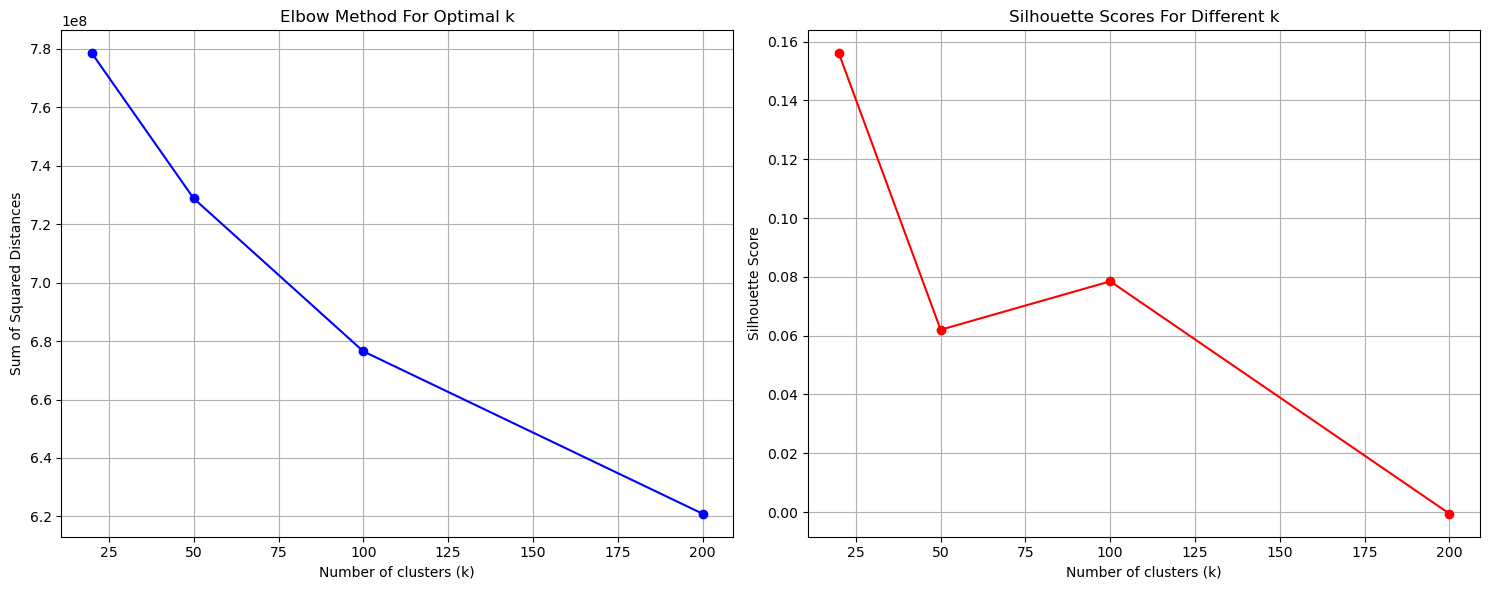

Best K based on silhouette score: 20 with score 0.1560


In [6]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np
import time

# Apply ChiSqSelector to reduce dimensions
print("Applying ChiSqSelector to reduce dimensions...")
# We need a label column for ChiSqSelector
# We'll create a temporary random label just for feature selection
from pyspark.sql.functions import rand
from pyspark.sql.types import IntegerType

# Add a temporary random label column (0-9) for feature selection
temp_data = rescaled_data.withColumn("temp_label", (rand() * 10).cast(IntegerType()))

# Select top 1000 features
selector = ChiSqSelector(numTopFeatures=1000, 
                        featuresCol="features", 
                        outputCol="selected_features", 
                        labelCol="temp_label")
selector_model = selector.fit(temp_data)
reduced_data = selector_model.transform(temp_data)

# Find optimal K using the Elbow Method
print("Finding optimal K using Elbow Method...")
cost = []
silhouette_scores = []
K = [20, 50, 100, 200]  # Try K from 10 to 140 in steps of 20
evaluator = ClusteringEvaluator(featuresCol="selected_features")

for k in K:
    print(f"Training K-means with k={k}...")
    kmeans = KMeans(k=k, seed=1, featuresCol="selected_features", maxIter=20)
    model = kmeans.fit(reduced_data)
    predictions = model.transform(reduced_data)
    cost.append(model.summary.trainingCost)
    
    # Calculate silhouette score
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    
    print(f"K={k}, Cost={model.summary.trainingCost:.2f}, Silhouette={silhouette:.4f}")

# Plot the elbow curve
plt.figure(figsize=(15, 6))

# Plot 1: Elbow curve
plt.subplot(1, 2, 1)
plt.plot(K, cost, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)

# Plot 2: Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Different k')
plt.grid(True)

plt.tight_layout()
plt.savefig('kmeans_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Find the best K based on silhouette score
best_k_index = np.argmax(silhouette_scores)
best_k = K[best_k_index]
print(f"Best K based on silhouette score: {best_k} with score {silhouette_scores[best_k_index]:.4f}")

# Train final K-means model with the best K
best_kmeans = KMeans(k=best_k, seed=1, featuresCol="selected_features")
best_kmeans_model = best_kmeans.fit(reduced_data)
kmeans_predictions = best_kmeans_model.transform(reduced_data)


These results highlight several fundamental limitations of K-means for our academic paper dataset:
- Low Silhouette Scores: Even the best score (0.1560) indicates weak cluster separation. A good clustering typically has silhouette scores above 0.5.
- Diminishing Returns: Increasing K beyond 20 actually worsens cluster quality, suggesting that forcing more granular clusters creates artificial boundaries.
- Fuzzy Boundaries: Academic research inherently spans multiple areas. 
- Redundancy with Categories: The ArXiv dataset already contains human-curated categories. K-means clusters with such low silhouette scores may not add significant value beyond these existing categories.
- High-Dimensional Challenges: K-means struggles with the "curse of dimensionality" in our high-dimensional text feature space, even after dimensionality reduction.

## Why LDA Might Be Better
LDA (Latent Dirichlet Allocation) has several advantages over K-means for academic papers:
- Topic Mixtures: LDA recognizes that documents contain multiple topics in different proportions, which matches how research papers actually work
- Interpretable Topics: Each topic is a distribution over words, making it easy to understand what each topic represents
- Complementary to Categories: While categories represent disciplines, LDA topics often represent research themes, methods, or applications that cut across disciplines
- Better for Text: LDA was specifically designed for text data, while K-means struggles with high-dimensional, sparse text vectors

## Evaluating and Implementing LDA for Topic Modeling

In this section, we evaluate and implement Latent Dirichlet Allocation (LDA) to enhance the search capabilities of our Elasticsearch index. LDA is a generative statistical model that allows us to discover the underlying topics within a collection of documents. By integrating topic modeling, we aim to provide a semantic layer that improves search relevance and discovery.

### Why Evaluate Different \( k \) Values?

1. **Perplexity**: This metric measures how well the model predicts a sample. Lower perplexity indicates a better fit to the data. By calculating perplexity for different numbers of topics (\( k \)), we can identify the model that best captures the data's structure.

2. **Coherence**: Although not directly supported in Spark, coherence measures the semantic similarity between high-scoring words in a topic. Higher coherence scores generally indicate more interpretable topics. While we don't calculate coherence here, it's a valuable metric to consider.

3. **Optimal Topic Discovery**: Evaluating models over a range of \( k \) values helps us identify the number of topics that provides the most meaningful and interpretable results, enhancing the search and discovery experience in Elasticsearch.

### Extracting Dominant Topics

- **Dominant Topic**: For each document, we extract the dominant topic, which is the topic with the highest probability. This helps in categorizing documents based on their most prominent theme.
- **Topic Distribution**: We also store the topic distribution as a JSON object, including only significant topics with a probability greater than 0.05. This provides a nuanced view of the document's thematic content.

### Benefits for Elasticsearch

1. **Topic-Based Search**: Users can search within specific topics, which can be more meaningful than simple keyword searches.
2. **Cross-Disciplinary Discovery**: LDA topics often capture themes that cut across traditional categories, allowing users to discover papers related by content rather than just by category.
3. **Recommendations**: Topic distributions can be used to recommend similar papers based on shared topics.

### Conclusion

By evaluating LDA models with different numbers of topics and integrating the best model into our Elasticsearch index, we ensure that our topic modeling is both effective and efficient. This approach provides users with more relevant and semantically rich search results, enhancing the overall search experience.

In [6]:
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, StringType
import numpy as np
import json
import matplotlib.pyplot as plt

# Create a checkpoint directory to help with memory management
spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoint")

# Define a range of k values to test
k_values = [10, 20, 30, 40, 50]

# Store results
perplexities = []
# coherences = []  # Placeholder for coherence scores

for k in k_values:
    # Create and fit the LDA model
    lda = LDA(k=k, maxIter=10, optimizer="online", featuresCol="features")
    lda_model = lda.fit(rescaled_data)
    
    # Calculate perplexity
    perplexity = lda_model.logPerplexity(rescaled_data)
    perplexities.append(perplexity)
    
    # Calculate coherence (this is a placeholder, as Spark doesn't directly support coherence)
    # coherence = calculate_coherence(lda_model, rescaled_data)
    # coherences.append(coherence)
    
    print(f"k={k}, Perplexity={perplexity}")

# Plot perplexity and coherence scores
plt.figure(figsize=(10, 5))
plt.plot(k_values, perplexities, label='Perplexity')
# plt.plot(k_values, coherences, label='Coherence')  # Uncomment if coherence is calculated
plt.xlabel('Number of Topics (k)')
plt.ylabel('Score')
plt.title('LDA Model Evaluation')
plt.legend()
plt.show()

# Fit the final LDA model with the best k (e.g., based on lowest perplexity)
best_k = k_values[np.argmin(perplexities)]
lda = LDA(k=best_k, maxIter=10, optimizer="online", featuresCol="features")
lda_model = lda.fit(rescaled_data)

# Transform the data to include topic distributions
topics_data = lda_model.transform(rescaled_data)

# Extract dominant topic for each document
@udf(returnType=IntegerType())
def get_dominant_topic(topic_distribution):
    return int(np.argmax(topic_distribution))

@udf(returnType=StringType())
def topic_dist_to_json(topic_dist):
    # Convert to regular Python list
    topics_list = topic_dist.toArray().tolist()
    # Keep only topics with significant probability (>0.05)
    significant_topics = {str(i): float(prob) for i, prob in enumerate(topics_list) if prob > 0.05}
    return json.dumps(significant_topics)

# Add topic information to the data
topics_data = topics_data.withColumn(
    "dominant_topic", 
    get_dominant_topic("topicDistribution")
).withColumn(
    "topic_distribution",
    topic_dist_to_json("topicDistribution")
)

# Prepare for Elasticsearch
es_ready_data = topics_data.select(
    "id", "title", "abstract", "authors", "categories",
    "dominant_topic", "topic_distribution"
)

# Show the top terms for each topic
topic_terms = lda_model.describeTopics(10)
topic_terms.show(truncate=False)

k=10, Perplexity=8.122655507594763
k=20, Perplexity=8.048374739491871


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_58732/3286409763.py", line 24, in <module>
    perplexity = lda_model.logPerplexity(rescaled_data)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/pyspark/ml/clustering.py", line 1506, in logPerplexity
    return self._call_java("logPerplexity", dataset)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 72, in _call_java
    return _java2py(sc, m(*java_args))
                        ^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1322, in __call__
    return_value = get_return_value(
                   ^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/pyspark/errors/exception

ConnectionRefusedError: [Errno 111] Connection refused

## Enhancing Search with Topic Modeling

After exploring K-means clustering and finding its limitations for our academic paper dataset (low silhouette scores of ~0.16), we've implemented Latent Dirichlet Allocation (LDA) as a more suitable approach for discovering topics in our arXiv papers.

### Why LDA is Better Than K-means for Academic Papers

1. **Documents Belong to Multiple Topics**: Unlike K-means which assigns each document to exactly one cluster, LDA recognizes that academic papers typically span multiple research areas with different proportions. A paper might be 70% about neural networks, 20% about computer vision, and 10% about optimization.

2. **Interpretable Topics**: Each LDA topic is represented as a probability distribution over words, making it easy to understand what each topic represents. This allows us to label topics with meaningful names based on their most probable terms.

3. **Complementary to Categories**: While arXiv categories represent formal disciplines (cs.AI, math.CO, etc.), LDA topics often capture research themes, methodologies, or applications that cut across these disciplines.

4. **Better for Text Data**: LDA was specifically designed for text documents, while K-means struggles with the high-dimensional, sparse vectors that represent text.

### How We're Using LDA

We've implemented a 20-topic LDA model with memory-efficient settings to handle our large corpus of 2.6+ million papers. For each document, we:

1. Extract the dominant topic (the topic with highest probability)
2. Store the topic distribution as a JSON object (including only significant topics with probability > 0.05)
3. Add this information to our Elasticsearch index

### Benefits for Search and Discovery

Adding topic information to our Elasticsearch index enables powerful search patterns:

1. **Topic-Filtered Search**: Users can search within specific topics (e.g., "neural networks" within the deep learning topic)
2. **Topic-Based Recommendations**: "Show me more papers on similar topics"
3. **Cross-Disciplinary Discovery**: Find papers that discuss similar topics but are classified in different disciplines
4. **Topic Trends Analysis**: Track how research topics evolve over time

The LDA model provides a semantic layer that goes beyond simple keyword matching, helping users discover relevant papers they might otherwise miss.

In [7]:
# Simplified LDA evaluation that avoids NumPy serialization issues

# 1. Examine top terms for each topic
print("\nTop terms for each LDA topic:")
topic_terms = lda_model.describeTopics(10)
print("LDA Topics:")
topic_terms.show(truncate=False)

# 2. Check topic distribution - how many documents per topic?
print("\nDocument distribution across topics:")
topic_distribution = topics_data.groupBy("dominant_topic").count().orderBy("count", ascending=False)
topic_distribution.show()

# 3. Compare with category information - most common category for each topic
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc, col

# Get the most common category for each topic
topic_category_df = topics_data.select("dominant_topic", "categories").withColumn(
    "primary_category", 
    col("categories")[0]  # Simplified - just take first category
)

# Count documents by topic and category
topic_category_counts = topic_category_df.groupBy("dominant_topic", "primary_category").count()

# Find the most common category for each topic
window_spec = Window.partitionBy("dominant_topic").orderBy(desc("count"))
topic_top_categories = topic_category_counts.withColumn(
    "rank", row_number().over(window_spec)
).filter("rank = 1").select("dominant_topic", "primary_category", "count")

print("\nMost common arXiv category for each LDA topic:")
topic_top_categories.orderBy("dominant_topic").show(truncate=False)

# 4. Now export to Elasticsearch
# print("\nExporting data with LDA topic information to Elasticsearch...")
# es_index_name = "arxiv_metadata"

# Use the es_ready_data DataFrame that includes topic information
# es_ready_data.write.format("org.elasticsearch.spark.sql") \
#     .option("es.nodes", "localhost") \
#     .option("es.port", "9200") \
#     .option("es.index.auto.create", "true") \
#     .option("es.mapping.id", "id") \
#     .option("es.nodes.wan.only", "true") \
#     .mode("overwrite") \
#     .save(f"{es_index_name}/_doc")



Top terms for each LDA topic:
LDA Topics:
+-----+------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                 |termWeights                                                                                                                                                                                                                         |
+-----+------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[697, 1734, 2402, 9456, 8307, 8157, 3590, 7102, 1216, 16

In [ ]:
es_index_name = "arxiv_metadata"

# Write the cleaned DataFrame to Elasticsearch
df_clean.write.format("org.elasticsearch.spark.sql") \
    .option("es.nodes", "localhost") \
    .option("es.port", "9200") \
    .option("es.index.auto.create", "false") \
    .option("es.mapping.id", "id") \
    .option("es.mapping.exclude", "id") \
    .option("es.nodes.wan.only", "true") \
    .mode("overwrite") \
    .save(f"{es_index_name}/_doc")
